In [206]:
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import dash_bio as dashbio
import os

from quality_control import *
from method1_analysis import *
from method2_analysis import *

# Table of Contents: <a id='start'></a>

1. [Loading the data](#loading-data)
2. [Filtering the data](#filtering)
2. [Method 1](#Method-1)
3. [Method 2](#Method-2)
4. [Compare the results](#Compare)

# Loading the data <a id='loading-data'></a>


## Data Analysed:

List of dnaids






In [207]:

# Todo: move file directories to config files, so that can be re-run with different counts

counts_dir ="/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results/counts"
outdir = 'tmp_output'
control_file = Path("/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results")/'controls.txt'

# Load
dnaids = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid1457', 'dnaid2015', 'dnaid2016', 'dnaid2017', 'dnaid2018', 'dnaid2019',
         'dnaid2023', 'dnaid2024', 'dnaid2025', 'dnaid2026', 'dnaid2027', 'dnaid2028', 'dnaid2029' ]


cnt_df = load_files(dnaids, Path(counts_dir))

# Create unique identifier for each sample
cnt_df['sampleID'] = cnt_df['sampleID'] + "_" + cnt_df['dnaid'] + "_" + cnt_df['experiment']
cnt_df = cnt_df[cnt_df.sampleID.notnull()]

# Dropping Unenriched samples
cnt_df = cnt_df[~cnt_df.sampleID.str.contains('unenriched')]
annotation_df = cnt_df[['barcode', 'ShortName', 'locus_tag', 'phenotype', 'conc']].drop_duplicates()


libraries = [lib for lib in cnt_df.library.unique() if type(lib) == str]
libraries.remove('library_14_1')
print(len(libraries))
days = ['_d1', '_d2', '_d3', '_d4']

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.



11


In [208]:
cnt_df.groupby('library').experiment.nunique().reset_index().sort_values('library')

,library,experiment
0,library_10_1,2
1,library_10_2,3
2,library_11_1,3
3,library_11_2,2
4,library_12_1,2
5,library_12_2,3
6,library_13_1,2
7,library_13_2,2
8,library_14_1,1
9,library_14_2,3


In [209]:
mice_per_library = cnt_df.groupby(['library', 'day']).sampleID.nunique().reset_index()
mice_per_library
# for library in mice_per_library.library.unique():
#     print (mice_per_library[mice_per_library.library == library])

,library,day,sampleID
0,library_10_1,d0,3
1,library_10_1,d1,21
2,library_10_1,d2,21
3,library_10_1,d3,21
4,library_10_1,d4,21
5,library_10_2,d0,5
6,library_10_2,d1,17
7,library_10_2,d2,16
8,library_10_2,d3,17
9,library_10_2,d4,17


## Summary:

From the above results, not enough data for library_14_1, should be dropped. At least attach warning to results.

# Filtering the data: <a id='filtering'></a>

## 1. [Checking for linearity of control dilutions](#check-linearity)

## 2. [Filtering out samples with skewed WT fitness ](#check-wt-fitness)


[Back to the start](#start)

[Next to Method 1](#Method-1)

[Next to Method 2](#Method-2)


# Checking for linearity of control dilutions <a id='check-linearity'></a>


- Cutting off samples with $R^2$ < 0.8

In [210]:
corr_df, good_samples = calculate_correlation(cnt_df, control_file, for_each='sampleID')
print(len(good_samples))

266


In [27]:
def viz_linearity(cnt_df, phenotype='wt', day='d0', library = 'library_10_2'):
    query = f"(phenotype == '{phenotype}') & (day == '{day}') & (library == '{library}')"
    df = cnt_df.query(query)[['barcode', 'sampleID', 'cnt', 'conc', 'library']]
    df['lconc'] = np.log(df.conc)
    df['lcnt'] = np.log(df.cnt +1)
    fig = px.scatter(df.sort_values('sampleID'), 
                     x="lconc", y="lcnt", facet_col="sampleID", facet_col_wrap=3,height=3000, width=800,
                     trendline='ols')
    return df, fig

In [28]:
wdf, fig= viz_linearity(cnt_df, day='d2', library='library_10_2')

# Filtering out samples with skewed WT fitness <a id='check-wt-fitness'></a>

- Median $log_2FC$ within -1/1 for WT barcodes
- Filtering out technical artifacts of unknown origin

### How to:
- Only used 'good samples' identified above
- Calculate barcode fitness for each lbirary.
    - For each experiment in each library:
        - Perform VST transformation
        - Calculate fitness for each barcode $\frac{2^{vst-barcode-counts}}{2^{vst-inoculum-counts}}$
- Calculate WT barcode fitnesses 
- Identify samples with abs($log_2FC$) > 1

[Back to the start](#start)

[Next to Method 1](#Method-1)

[Next to Method 2](#Method-2)


In [213]:
skewed_samples = []
no_inoc_samples = []
all_wt_fit = []
for library in libraries:
    print(library)
    library_vst, library_barcode_fitness = get_barcode_fitness_by_library(cnt_df, library, good_samples, outdir, filter_below=0)
    library_wt_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='wt')
    all_wt_fit.append(library_wt_fitness.assign(library=library))
    no_inoc_samples += list(library_wt_fitness.isna().all()[lambda x: x].index)
    skewed_samples += list(get_skewed(library_wt_fitness))

library_11_1
Number of unique experiments after filtering: 3
Design: experiment+day
library_15_1
Number of unique experiments after filtering: 1
Design: day
library_13_2
Number of unique experiments after filtering: 1
Design: day
library_10_1
Number of unique experiments after filtering: 1
Design: day
library_9_1
Number of unique experiments after filtering: 1
Design: day
library_11_2
Number of unique experiments after filtering: 2
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



library_12_1
Number of unique experiments after filtering: 1
Design: day
library_12_2
Number of unique experiments after filtering: 3
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



library_13_1
Number of unique experiments after filtering: 2
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



library_14_2
Number of unique experiments after filtering: 3
Design: experiment+day
library_10_2
Number of unique experiments after filtering: 3
Design: experiment+day


In [214]:
no_inoc_samples

['w435_d3_dnaid1457_TV3522A',
 'w436_d3_dnaid1457_TV3522A',
 'w441_d4_dnaid1457_TV3522C',
 'w443_d4_dnaid1457_TV3522C',
 'w445_d4_dnaid1457_TV3522D',
 'w446_d3_dnaid1457_TV3522D',
 'w446_d4_dnaid1457_TV3522D']

In [215]:
skewed_samples

['am366_d3_dnaid2026_TV5536C',
 'ad737_d4_dnaid2016_TV4570',
 'ad312_d2_dnaid2019_TV4518',
 'ad312_d3_dnaid2019_TV4518',
 'ad310_d4_dnaid2019_TV4518',
 'ad310_d3_dnaid2019_TV4518',
 'ad309_d2_dnaid2019_TV4518',
 'am492_d4_dnaid2027_TV5563B',
 'am493_d1_dnaid2027_TV5563B',
 'am738_d1_dnaid2028_TV5585C',
 'am733_d1_dnaid2028_TV5585C',
 'am487_d1_dnaid2027_TV5563A',
 'am732_d1_dnaid2028_TV5585A']

In [228]:
all_wt_fit[3].library.unique()

array(['library_10_1'], dtype=object)

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



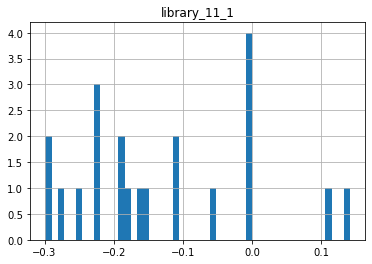

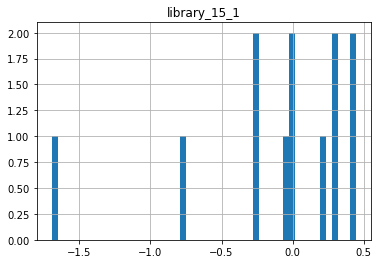

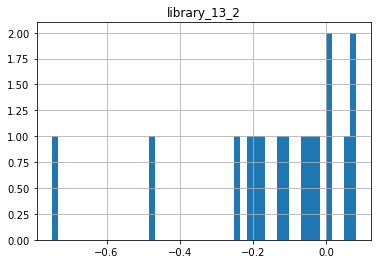

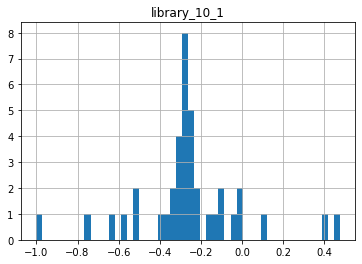

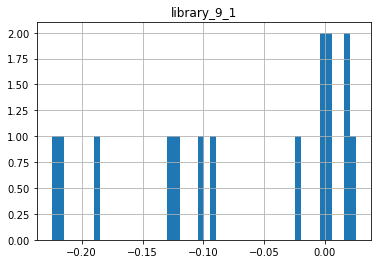

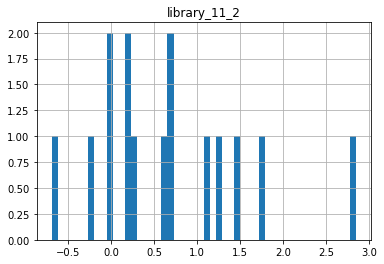

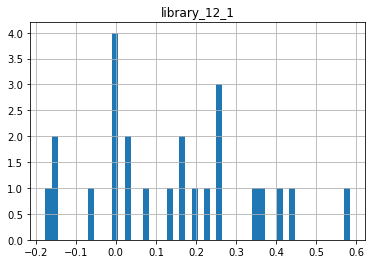

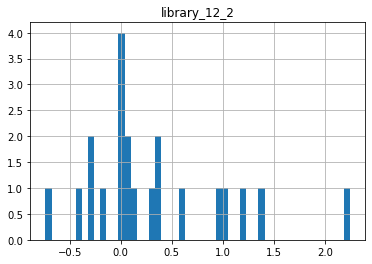

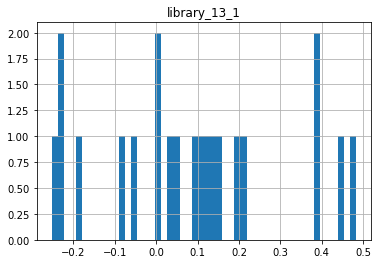

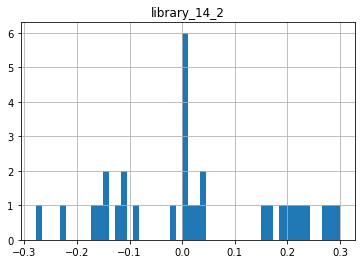

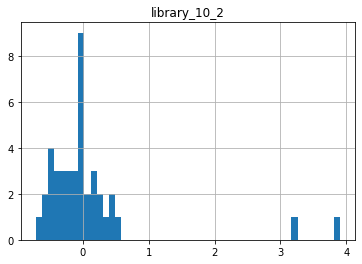

In [239]:
for wt in all_wt_fit:
    fig = plt.figure()
    plt.title(wt.library.unique()[0])
    np.log2(wt.drop(['conc'], axis=1).median()).hist(bins=50)
    fig.show()

In [240]:
with open(Path(outdir)/'skewed_samples.txt', 'w') as fh:
    for s in skewed_samples:
        fh.write(f"{s}\n")

# Method 1: <a id='Method-1'></a>


- Take all the library samples, run DESeq to get fitness values


[Back to the start](#start)

In [241]:
with open(Path(outdir)/"skewed_samples.txt", 'r') as fh:
    skewed_samples = [s.strip() for s in fh.readlines()]

In [242]:
skewed_samples

['am366_d3_dnaid2026_TV5536C',
 'ad737_d4_dnaid2016_TV4570',
 'ad312_d2_dnaid2019_TV4518',
 'ad312_d3_dnaid2019_TV4518',
 'ad310_d4_dnaid2019_TV4518',
 'ad310_d3_dnaid2019_TV4518',
 'ad309_d2_dnaid2019_TV4518',
 'am492_d4_dnaid2027_TV5563B',
 'am493_d1_dnaid2027_TV5563B',
 'am738_d1_dnaid2028_TV5585C',
 'am733_d1_dnaid2028_TV5585C',
 'am487_d1_dnaid2027_TV5563A',
 'am732_d1_dnaid2028_TV5585A']

## Remove skewed and samples with no inoculum, filter 1000

In [186]:
results = []
for library in libraries:
    print(library)
    lib_df = cnt_df[cnt_df.library == library].copy()
    #Removing some noise
    lib_df = lib_df[~((lib_df.libcnt.isna()) & (lib_df.phenotype.isna()))]
    library_samples = [s for s in good_samples if s in lib_df.sampleID.unique() and s not in skewed_samples 
                      and s not in no_inoc_samples]
    fit, res = analyze_library(lib_df, sample_id="sampleID", 
                          good_samples=library_samples, 
                          dnaid=library.replace("_", "-"), experiment='', 
                          control_file=control_file, 
                          to_filter=1000, outdir=outdir)
    results.append(res)
    
method1_skewed_removed = pd.concat(results)

library_11_1
Counter({'d1': 6, 'd2': 6, 'd3': 6, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 3
Design: experiment+day
Running DESeq2
Calculating z-scores
Summarizing
library_15_1
Counter({'d2': 3, 'd1': 3, 'd3': 3, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_13_2
Counter({'d1': 7, 'd2': 5, 'd3': 2, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_10_1
Counter({'d1': 13, 'd2': 11, 'd3': 8, 'd4': 4})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_9_1
Counter({'d1': 6, 'd2': 4, 'd3': 3})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_11_2
Counter({'d2': 3, 'd1': 3, 'd3': 2, 'd4': 1})
Filtering Dat

## Remove skewed and samples with no inoculum, filter 100

In [243]:
results = []
for library in libraries:
    print(library)
    lib_df = cnt_df[cnt_df.library == library].copy()
    #Removing some noise
    lib_df = lib_df[~((lib_df.libcnt.isna()) & (lib_df.phenotype.isna()))]
    library_samples = [s for s in good_samples if s in lib_df.sampleID.unique() and s not in skewed_samples 
                      and s not in no_inoc_samples]
    fit, res = analyze_library(lib_df, sample_id="sampleID", 
                          good_samples=library_samples, 
                          dnaid=library.replace("_", "-"), experiment='', 
                          control_file=control_file, 
                          to_filter=100, outdir=outdir)
    results.append(res)
    
method1_skewed_removed_100 = pd.concat(results)

library_11_1
Counter({'d1': 6, 'd2': 6, 'd3': 6, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 3
Design: experiment+day
Running DESeq2
Calculating z-scores
Summarizing
library_15_1
Counter({'d2': 3, 'd1': 3, 'd3': 3, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_13_2
Counter({'d1': 7, 'd2': 5, 'd3': 2, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_10_1
Counter({'d1': 13, 'd2': 11, 'd3': 8, 'd4': 4})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_9_1
Counter({'d1': 6, 'd2': 4, 'd3': 3})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_11_2
Counter({'d2': 3, 'd1': 3, 'd3': 2, 'd4': 1})
Filtering Dat

In [187]:
results = []
for library in libraries:
    print(library)
    lib_df = cnt_df[cnt_df.library == library].copy()
    #Removing some noise
    lib_df = lib_df[~((lib_df.libcnt.isna()) & (lib_df.phenotype.isna()))]
    library_samples = [s for s in good_samples if s in lib_df.sampleID.unique() if s not in no_inoc_samples]
    fit, res = analyze_library(lib_df, sample_id="sampleID", 
                          good_samples=library_samples, 
                          dnaid=library.replace("_", "-"), experiment='', 
                          control_file=control_file, 
                          to_filter=1000, outdir=outdir)
    results.append(res)
    
method1_with_skewed = pd.concat(results)

library_11_1
Counter({'d1': 6, 'd2': 6, 'd3': 6, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 3
Design: experiment+day
Running DESeq2
Calculating z-scores
Summarizing
library_15_1
Counter({'d3': 4, 'd2': 3, 'd1': 3, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_13_2
Counter({'d1': 7, 'd2': 5, 'd3': 2, 'd4': 1})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_10_1
Counter({'d1': 13, 'd2': 11, 'd3': 8, 'd4': 5})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_9_1
Counter({'d1': 6, 'd2': 4, 'd3': 3})
Filtering Dataset
Number of unique experiments after filtering: 1
Design: day
Running DESeq2
Calculating z-scores
Summarizing
library_11_2
Counter({'d2': 5, 'd3': 4, 'd1': 3, 'd4': 2})
Filtering Dat

In [244]:
method1_skewed_removed_100.to_csv(Path(outdir)/"21-07-method1_skewed_removed_100.csv")

In [188]:
method1_skewed_removed.to_csv(Path(outdir)/"21-07-method1_skewed_removed.csv")
method1_with_skewed.to_csv(Path(outdir)/"21-07-method1_with_skewed.csv")

# Method 2: <a id='Method-2'></a>

[Back to the start](#start)

In [321]:
good_samples_noskew = [s for s in good_samples if s not in skewed_samples and s not in no_inoc_samples]
vsts = {}
fits = []
cis = []
wt_fits = []
ssa_ci = []
resultsFitList = []
resultsCIList=[]
# Fitness Results
for library in libraries:
    print(library)
    library_vst, library_barcode_fitness = get_barcode_fitness_by_library(cnt_df, library, good_samples_noskew, outdir, filter_below=1000)
    library_gene_fitness = get_gene_fitness_by_library(library_barcode_fitness, annotation_df)
    library_wt_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='wt')
    library_ssa_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='ssaV_invG')
    library_gene_ci = library_gene_fitness.set_index('ShortName').apply(lambda x: x / library_wt_fitness.median()[x.name]).reset_index()
    library_ssa_ci = library_ssa_fitness.median()/library_wt_fitness.median()
    meltGeneFit = melt_sampleID(library_gene_fitness, idVar=['ShortName'], value_name='fitness')
    meltWtFit = melt_sampleID(library_wt_fitness, idVar=['barcode', 'phenotype', 'conc'], value_name='fitness')
    meltGeneCI = melt_sampleID(library_gene_ci, idVar=['ShortName'], value_name='ci')
    resultsFit = get_library_results(meltGeneFit, meltWtFit, library)
    resultsCI = get_library_results_ci(meltGeneCI, library_ssa_ci, library)
    
    fits.append(meltGeneFit.assign(library=library))
    cis.append(meltGeneCI.assign(library=library))
    wt_fits.append(meltWtFit.assign(library=library))
    resultsFitList.append(resultsFit)
    resultsCIList.append(resultsCI)
    ssa_ci.append(pd.DataFrame(library_ssa_ci, columns=['ssa_ci']).assign(library=library))
    vsts[library]= library_vst
      
m2_fits_no_skew = pd.concat(fits)
m2_ci_no_skew = pd.concat(cis)
m2_wt_fits_no_skew = pd.concat(wt_fits)
m2_results_fit_no_skew = pd.concat(resultsFitList)
m2_results_ci_no_skew = pd.concat(resultsCIList)
m2_ssa_ci_no_skew = pd.concat(ssa_ci)

library_11_1
Number of unique experiments after filtering: 3
Design: experiment+day
d3
d1
d2
d3
d1
d2
library_15_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_13_2
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d2
d1
d3
library_10_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d4
d2
d1
d3
d4
library_9_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_11_2
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_12_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d4
d3
d2
d1
d4
d3
library_12_2
Number of unique experiments after filtering: 2
Design: experiment+day
d2
d3
d4
d1
d2
d3
d4
d1
library_13_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d4
d3
d2
d1
d4
d3
library_14_2
Number of unique experiments after filtering: 3
Design: experiment+day
d1
d2
d4
d3
d1
d2
d4
d3
library_10_2
Number of uniqu

In [391]:
sample_map = {s:['median'] for s in library_vst}
sample_map

{'ad930_d1_dnaid2017_TV4592A': ['median'],
 'ad926_d2_dnaid2017_TV4592A': ['median'],
 'ad928_d2_dnaid2017_TV4592A': ['median'],
 'ad926_d1_dnaid2017_TV4592A': ['median'],
 'ad928_d1_dnaid2017_TV4592A': ['median'],
 'ad930_d2_dnaid2017_TV4592A': ['median'],
 'inoculum_d0_dnaid2017_TV4592A': ['median'],
 'ad929_d1_dnaid2017_TV4592A': ['median'],
 'ad927_d4_dnaid2018_TV4592A': ['median'],
 'ad926_d3_dnaid2018_TV4592A': ['median'],
 'ad927_d3_dnaid2018_TV4592A': ['median'],
 'ad926_d4_dnaid2018_TV4592A': ['median'],
 'ad930_d4_dnaid2018_TV4592A': ['median'],
 'ad930_d3_dnaid2018_TV4592A': ['median'],
 'ad929_d3_dnaid2018_TV4592A': ['median'],
 'ad929_d4_dnaid2018_TV4592A': ['median'],
 'inoculum_d0_dnaid2018_TV4592A': ['median'],
 'am486_d2_dnaid2027_TV5563A': ['median'],
 'am483_d2_dnaid2027_TV5563A': ['median'],
 'am488_d2_dnaid2027_TV5563A': ['median'],
 'inoculum_d0_dnaid2027_TV5563A': ['median'],
 'am486_d3_dnaid2027_TV5563A': ['median'],
 'am486_d4_dnaid2027_TV5563A': ['median'],
 '

In [434]:
genes

Index(['agaR', 'glpT', 'GAATCTATGCCCGTGCA', 'ompR', 'rfaJ', 'uhpC', 'rfbD',
       'wcaD', 'wcaC', 'GACAAACGGCGACGTTA', 'TCAGTAGGTAGTGACAA',
       'TAAGTCTTTAGGGTCCG', 'CTGATGCCTAATCACAG', 'rfaL', 'spvC', 'SL1344_3009',
       'ACCTAGTGACAGACCAG', 'torD', 'GGATCACATCCCGCTCC', 'ACTTTCCCATCATTAAC',
       'GAAGGGCCCGGGACACG', 'yneA', 'frdC', 'yhcK', 'AACCCCGATGGGGCACA',
       'SL1344_3740', 'GTGCCCTCCGATGTGGC', 'dpaL', 'nlpD', 'SL1344_3563',
       'aph(3'')-Ib', 'SL1344_RS24725', 'TAAATCAATTAATATCG',
       'CCGTAAACCAGAGCGAA', 'yjiN', 'gatD', 'SL1344_RS24665', 'SL1344_4017',
       'ACAAAAGGACCCAGAAC', 'yhfL', 'wcaA', 'ACCCAGCCCAACTCGTA', 'tnp',
       'TATTACGCACAGCGGGG', 'SL1344_1597', 'yojN', 'GGCCACGATTCAATAGC',
       'AAAGAAGCTATAAACTA', 'yccD', 'SL1344_3743'],
      dtype='object', name='ShortName')

,ad934_d1_dnaid2017_TV4592B,ad936_d2_dnaid2017_TV4592B,ad936_d1_dnaid2017_TV4592B,inoculum_d0_dnaid2017_TV4592B,ad931_d2_dnaid2017_TV4592B,ad934_d2_dnaid2017_TV4592B,ad935_d1_dnaid2017_TV4592B,ad932_d1_dnaid2017_TV4592B,ad931_d1_dnaid2017_TV4592B,ad933_d1_dnaid2017_TV4592B,...,al978_d1_dnaid2023_TV5490C,al977_d1_dnaid2023_TV5490C,al976_d2_dnaid2023_TV5490C,al978_d3_dnaid2024_TV5490C,inoculum_d0_dnaid2024_TV5490C,al978_d4_dnaid2024_TV5490C,am359_d2_dnaid2025_TV5536B,inoculum_d0_dnaid2025_TV5536B,am359_d1_dnaid2025_TV5536B,inoculum_d0_dnaid2026_TV5536B
ad934_d1_dnaid2017_TV4592B,1.000000,0.902063,0.964955,0.418649,0.881652,0.857149,0.935004,0.899166,0.894622,0.896105,...,0.804045,0.730139,0.535011,0.621235,0.094379,0.501328,0.750471,0.218723,0.790928,0.219549
ad936_d2_dnaid2017_TV4592B,0.902063,1.000000,0.910060,0.298756,0.896033,0.887634,0.891891,0.845350,0.864154,0.909365,...,0.741447,0.623325,0.409346,0.581913,-0.036842,0.518843,0.620470,0.041355,0.650932,0.040470
ad936_d1_dnaid2017_TV4592B,0.964955,0.910060,1.000000,0.424979,0.870658,0.834431,0.967392,0.924717,0.943647,0.929209,...,0.804764,0.729307,0.460869,0.595808,0.108106,0.490580,0.685117,0.187814,0.747743,0.188615
inoculum_d0_dnaid2017_TV4592B,0.418649,0.298756,0.424979,1.000000,0.334126,0.253904,0.410177,0.260774,0.483821,0.419440,...,0.395118,0.612878,0.106045,0.048488,0.742125,-0.088729,0.313797,0.690036,0.429881,0.689751
ad931_d2_dnaid2017_TV4592B,0.881652,0.896033,0.870658,0.334126,1.000000,0.830434,0.874510,0.802627,0.904249,0.899270,...,0.704141,0.678696,0.406193,0.538823,-0.030873,0.508420,0.636342,0.030632,0.736600,0.028310
ad934_d2_dnaid2017_TV4592B,0.857149,0.887634,0.834431,0.253904,0.830434,1.000000,0.829080,0.759308,0.788674,0.792081,...,0.705145,0.619837,0.510015,0.560949,0.008569,0.454596,0.663235,0.080433,0.639680,0.081839
ad935_d1_dnaid2017_TV4592B,0.935004,0.891891,0.967392,0.410177,0.874510,0.829080,1.000000,0.895856,0.940742,0.944391,...,0.801031,0.726681,0.428880,0.526278,0.089493,0.440689,0.659538,0.167172,0.721985,0.165933
ad932_d1_dnaid2017_TV4592B,0.899166,0.845350,0.924717,0.260774,0.802627,0.759308,0.895856,1.000000,0.830892,0.843413,...,0.688164,0.573153,0.415447,0.579546,-0.065105,0.515428,0.637998,0.047819,0.663500,0.044910
ad931_d1_dnaid2017_TV4592B,0.894622,0.864154,0.943647,0.483821,0.904249,0.788674,0.940742,0.830892,1.000000,0.923370,...,0.754874,0.716087,0.349524,0.483380,0.132115,0.412625,0.626317,0.136018,0.738804,0.136725
ad933_d1_dnaid2017_TV4592B,0.896105,0.909365,0.929209,0.419440,0.899270,0.792081,0.944391,0.843413,0.923370,1.000000,...,0.759125,0.703006,0.359055,0.493217,0.076825,0.417848,0.640539,0.117102,0.716344,0.117345


In [445]:
sample_map = {s:['median'] for s in vsts['library_14_2']}
test_gene = (vsts['library_14_2'].reset_index()
 .merge(annotation_df, on='barcode').drop(['locus_tag', 'phenotype', 'conc'], axis=1)
 .set_index('barcode')
 .groupby('ShortName').agg(sample_map))
test_gene.columns = [c[0] for c in test_gene.columns]
genes = test_gene.var(axis=1).sort_values(ascending=False).head(50).index
test_gene = test_gene.loc[genes]
df, pc1, pc2 = get_pca_df(test_gene)
plotPCA(df, pc1,pc2)

In [453]:
from sklearn.decomposition import PCA

def get_pca_df(library_vst, num_genes=500):
    var_bcs = library_vst.var(axis=1).sort_values(ascending=False).head(num_genes).index
    df = library_vst.loc[var_bcs]
    meta = library_vst.T.reset_index().rename({'index':'sampleID'}, axis=1)
    new = meta.sampleID.str.split("_", expand=True)
    new.columns = ['mouse', 'day', 'dnaid', 'experiment']
    meta = pd.concat([meta[['sampleID']], new], axis=1).set_index('sampleID')
    pDf, pc1_var, pc2_var = find_pc1_pc2(df, meta)
    return pDf, pc1_var, pc2_var


def plotPCA(pDf, pc1, pc2, title=""):
    fig = px.scatter(pDf.sort_values('day'), x='PC1', y='PC2', color='day', symbol='experiment', hover_data=['mouse'],
              template='simple_white', title=title,
              color_discrete_sequence=px.colors.qualitative.G10,
                labels ={'PC1': f'PC1, {pc1}%',
                        'PC2': f'PC2, {pc2}%',
                        'day': 'Day',
                        'experiment': 'Experiment'})


    fig.update_traces(marker=dict(size=12,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))

    fig.update_layout(
        font_family="Arial",
        font_size=14,
        title_font_size=24,
        title_x=0.5
    )
    return fig

In [459]:
pDf, pc1, pc2 = get_pca_df(vsts['library_10_2'], 50)
plotPCA(pDf, pc1, pc2)

In [364]:
figs = []

for library in libraries:
    pDf, pc1, pc2 = get_pca_df(vsts[library])
    figs.append(plotPCA(pDf, pc1, pc2, library))
                


In [370]:
with open(Path(outdir)/'PCA_barcode_abundance.html', 'a') as f:
    for fig in figs:
        f.write(fig.to_html())
    

In [447]:
figs[0]

In [449]:
figs[1]

In [451]:
figs[2]

In [452]:
figs[3]

In [463]:
test_gene.corr()

,ad934_d1_dnaid2017_TV4592B,ad936_d2_dnaid2017_TV4592B,ad936_d1_dnaid2017_TV4592B,inoculum_d0_dnaid2017_TV4592B,ad931_d2_dnaid2017_TV4592B,ad934_d2_dnaid2017_TV4592B,ad935_d1_dnaid2017_TV4592B,ad932_d1_dnaid2017_TV4592B,ad931_d1_dnaid2017_TV4592B,ad933_d1_dnaid2017_TV4592B,...,al978_d1_dnaid2023_TV5490C,al977_d1_dnaid2023_TV5490C,al976_d2_dnaid2023_TV5490C,al978_d3_dnaid2024_TV5490C,inoculum_d0_dnaid2024_TV5490C,al978_d4_dnaid2024_TV5490C,am359_d2_dnaid2025_TV5536B,inoculum_d0_dnaid2025_TV5536B,am359_d1_dnaid2025_TV5536B,inoculum_d0_dnaid2026_TV5536B
ad934_d1_dnaid2017_TV4592B,1.000000,0.902063,0.964955,0.418649,0.881652,0.857149,0.935004,0.899166,0.894622,0.896105,...,0.804045,0.730139,0.535011,0.621235,0.094379,0.501328,0.750471,0.218723,0.790928,0.219549
ad936_d2_dnaid2017_TV4592B,0.902063,1.000000,0.910060,0.298756,0.896033,0.887634,0.891891,0.845350,0.864154,0.909365,...,0.741447,0.623325,0.409346,0.581913,-0.036842,0.518843,0.620470,0.041355,0.650932,0.040470
ad936_d1_dnaid2017_TV4592B,0.964955,0.910060,1.000000,0.424979,0.870658,0.834431,0.967392,0.924717,0.943647,0.929209,...,0.804764,0.729307,0.460869,0.595808,0.108106,0.490580,0.685117,0.187814,0.747743,0.188615
inoculum_d0_dnaid2017_TV4592B,0.418649,0.298756,0.424979,1.000000,0.334126,0.253904,0.410177,0.260774,0.483821,0.419440,...,0.395118,0.612878,0.106045,0.048488,0.742125,-0.088729,0.313797,0.690036,0.429881,0.689751
ad931_d2_dnaid2017_TV4592B,0.881652,0.896033,0.870658,0.334126,1.000000,0.830434,0.874510,0.802627,0.904249,0.899270,...,0.704141,0.678696,0.406193,0.538823,-0.030873,0.508420,0.636342,0.030632,0.736600,0.028310
ad934_d2_dnaid2017_TV4592B,0.857149,0.887634,0.834431,0.253904,0.830434,1.000000,0.829080,0.759308,0.788674,0.792081,...,0.705145,0.619837,0.510015,0.560949,0.008569,0.454596,0.663235,0.080433,0.639680,0.081839
ad935_d1_dnaid2017_TV4592B,0.935004,0.891891,0.967392,0.410177,0.874510,0.829080,1.000000,0.895856,0.940742,0.944391,...,0.801031,0.726681,0.428880,0.526278,0.089493,0.440689,0.659538,0.167172,0.721985,0.165933
ad932_d1_dnaid2017_TV4592B,0.899166,0.845350,0.924717,0.260774,0.802627,0.759308,0.895856,1.000000,0.830892,0.843413,...,0.688164,0.573153,0.415447,0.579546,-0.065105,0.515428,0.637998,0.047819,0.663500,0.044910
ad931_d1_dnaid2017_TV4592B,0.894622,0.864154,0.943647,0.483821,0.904249,0.788674,0.940742,0.830892,1.000000,0.923370,...,0.754874,0.716087,0.349524,0.483380,0.132115,0.412625,0.626317,0.136018,0.738804,0.136725
ad933_d1_dnaid2017_TV4592B,0.896105,0.909365,0.929209,0.419440,0.899270,0.792081,0.944391,0.843413,0.923370,1.000000,...,0.759125,0.703006,0.359055,0.493217,0.076825,0.417848,0.640539,0.117102,0.716344,0.117345


<Figure size 1440x1440 with 0 Axes>

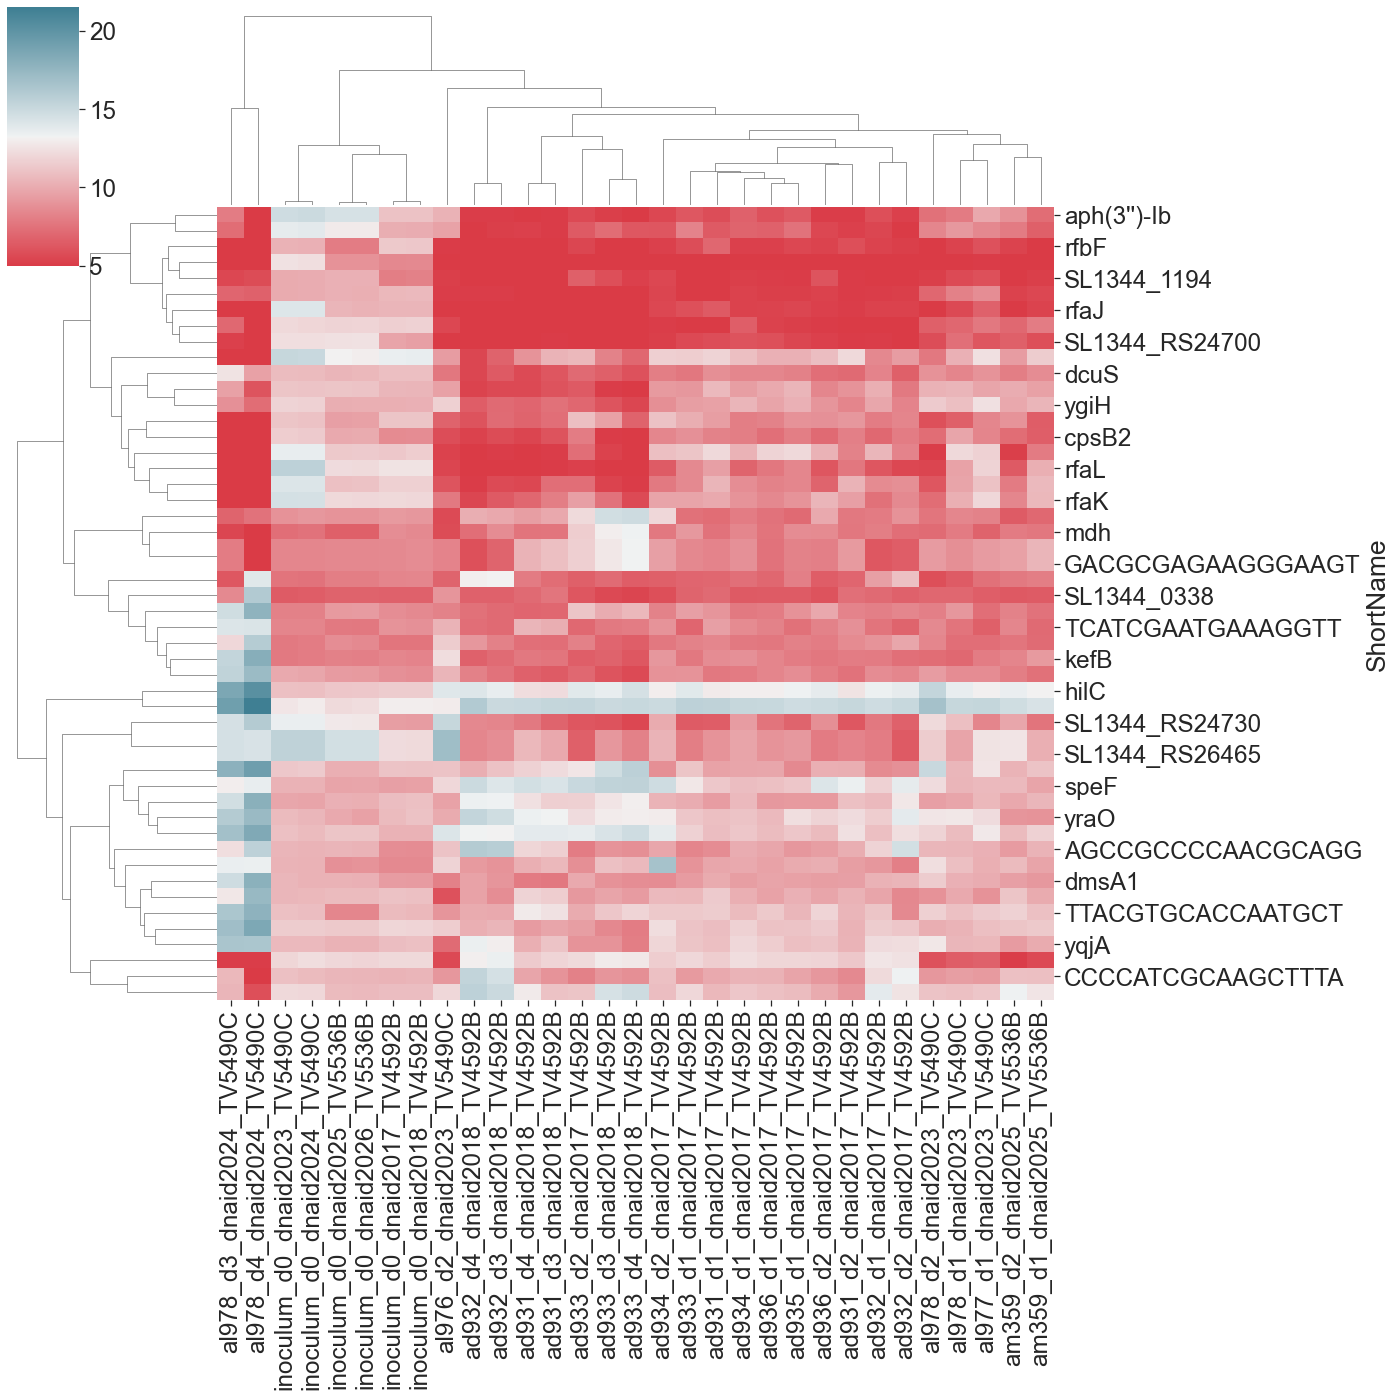

In [477]:
import seaborn as sns
fig = plt.figure(figsize=(20,20))
ax = sns.clustermap(
    test_gene, 
    cmap=sns.diverging_palette(10, 220, n=256),
    
    figsize=(20,20)
)

,ad934_d1_dnaid2017_TV4592B,ad936_d2_dnaid2017_TV4592B,ad936_d1_dnaid2017_TV4592B,inoculum_d0_dnaid2017_TV4592B,ad931_d2_dnaid2017_TV4592B,ad934_d2_dnaid2017_TV4592B,ad935_d1_dnaid2017_TV4592B,ad932_d1_dnaid2017_TV4592B,ad931_d1_dnaid2017_TV4592B,ad933_d1_dnaid2017_TV4592B,...,al978_d1_dnaid2023_TV5490C,al977_d1_dnaid2023_TV5490C,al976_d2_dnaid2023_TV5490C,al978_d3_dnaid2024_TV5490C,inoculum_d0_dnaid2024_TV5490C,al978_d4_dnaid2024_TV5490C,am359_d2_dnaid2025_TV5536B,inoculum_d0_dnaid2025_TV5536B,am359_d1_dnaid2025_TV5536B,inoculum_d0_dnaid2026_TV5536B
ad931_d1_dnaid2017_TV4592B,0.894622,0.864154,0.943647,0.483821,0.904249,0.788674,0.940742,0.830892,1.000000,0.923370,...,0.754874,0.716087,0.349524,0.483380,0.132115,0.412625,0.626317,0.136018,0.738804,0.136725
ad931_d2_dnaid2017_TV4592B,0.881652,0.896033,0.870658,0.334126,1.000000,0.830434,0.874510,0.802627,0.904249,0.899270,...,0.704141,0.678696,0.406193,0.538823,-0.030873,0.508420,0.636342,0.030632,0.736600,0.028310
ad931_d3_dnaid2018_TV4592B,0.816642,0.824675,0.754585,0.191120,0.881105,0.812816,0.720907,0.725989,0.709328,0.753548,...,0.594693,0.575440,0.500467,0.628458,-0.135563,0.569854,0.691919,-0.025922,0.687396,-0.028879
ad931_d4_dnaid2018_TV4592B,0.792047,0.789864,0.730747,0.154987,0.818627,0.785137,0.692709,0.735884,0.657764,0.713292,...,0.576063,0.540021,0.553724,0.666977,-0.147004,0.600645,0.723210,-0.015813,0.664736,-0.020214
ad932_d1_dnaid2017_TV4592B,0.899166,0.845350,0.924717,0.260774,0.802627,0.759308,0.895856,1.000000,0.830892,0.843413,...,0.688164,0.573153,0.415447,0.579546,-0.065105,0.515428,0.637998,0.047819,0.663500,0.044910
ad932_d2_dnaid2017_TV4592B,0.802718,0.801880,0.800850,0.164623,0.815740,0.710014,0.787319,0.920729,0.715850,0.774719,...,0.596153,0.498562,0.336531,0.507772,-0.152371,0.500556,0.525838,-0.017179,0.594712,-0.024181
ad932_d3_dnaid2018_TV4592B,0.742356,0.718071,0.706655,0.102516,0.698212,0.672159,0.671030,0.852900,0.560721,0.655043,...,0.503822,0.430381,0.432119,0.576096,-0.187717,0.544846,0.586249,-0.025902,0.559593,-0.032712
ad932_d4_dnaid2018_TV4592B,0.716917,0.704099,0.693563,0.074418,0.672200,0.657993,0.655615,0.851965,0.547082,0.632123,...,0.505770,0.403686,0.428488,0.602570,-0.192942,0.576409,0.576201,-0.022678,0.528234,-0.029919
ad933_d1_dnaid2017_TV4592B,0.896105,0.909365,0.929209,0.419440,0.899270,0.792081,0.944391,0.843413,0.923370,1.000000,...,0.759125,0.703006,0.359055,0.493217,0.076825,0.417848,0.640539,0.117102,0.716344,0.117345
ad933_d2_dnaid2017_TV4592B,0.709122,0.838627,0.675846,0.139224,0.827588,0.731843,0.699054,0.639553,0.662476,0.813808,...,0.534731,0.466242,0.264967,0.427473,-0.223517,0.376894,0.519902,-0.125611,0.551021,-0.124803


In [280]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))

    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False):
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(25, 15))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(frameon=True)
    return fig


In [294]:
test_df.columns = [c[1] for c in test_df.columns]
test_df

,inoculum_d0_dnaid1315_TV3371A,inoculum_d0_dnaid1315_TV3371B,inoculum_d0_dnaid1315_TV3379,u402_d1_dnaid1315_TV3371A,u402_d2_dnaid1315_TV3371A,u402_d3_dnaid1315_TV3371A,u405_d1_dnaid1315_TV3371B,u405_d2_dnaid1315_TV3371B,u405_d3_dnaid1315_TV3371B,u406_d1_dnaid1315_TV3371B,...,u406_d3_dnaid1315_TV3371B,u441_d1_dnaid1315_TV3379,u441_d2_dnaid1315_TV3379,u441_d3_dnaid1315_TV3379,u442_d1_dnaid1315_TV3379,u442_d2_dnaid1315_TV3379,u442_d3_dnaid1315_TV3379,u443_d1_dnaid1315_TV3379,u443_d2_dnaid1315_TV3379,u443_d3_dnaid1315_TV3379
barcode,,,,,,,,,,,,,,,,,,,,,
CGTTACCATAGCGTCAA,14.453154,13.953948,14.802377,7.736728,1.725065,8.701358,8.245210,3.933540,2.362841,9.187254,...,1.638263,10.797331,1.939024,0.499666,11.497988,3.469378,8.531187,11.844748,2.984677,1.938848
GGGGTATGAAACTTAAG,8.426436,8.458890,7.831939,8.757570,9.655828,17.188055,9.901286,10.215782,12.682195,8.861013,...,17.850552,11.252479,18.180304,20.103957,13.427606,18.353631,19.618595,10.073921,10.749587,18.236497
ACGCAGACCCTCACTTT,17.244081,15.487334,15.609834,15.033041,13.159885,11.976202,14.371839,14.344781,11.063182,14.920172,...,10.819690,13.553996,12.640444,1.589902,11.799330,12.799756,7.016862,12.097292,14.919114,9.116113
GATCACCCTAATCCAGC,10.733598,9.502586,10.282870,3.854613,0.769581,8.724782,3.675540,1.449001,1.080277,4.857445,...,0.539571,6.098325,1.300843,0.499666,5.607260,1.514746,2.188091,5.481892,0.922737,1.493020
TTCGTACACCATGAGGT,7.862749,10.293259,11.916043,0.737768,0.543441,0.671193,1.101563,0.518000,0.755791,1.544552,...,1.062171,1.151884,0.729350,1.937244,1.994596,0.969957,1.097754,1.682217,0.562137,1.278577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGACCCCCATAGCCCA,7.968997,7.966855,7.287912,5.977648,6.096365,6.068976,6.405987,6.503935,6.160777,5.961446,...,5.793159,7.904246,8.607727,10.511311,7.761480,8.339892,8.998277,7.491264,6.836635,7.480021
GCAGCGCAGCCCGATAG,6.550774,5.983309,6.402632,6.828191,6.688868,7.091652,5.933875,5.840893,8.007400,6.241048,...,6.588664,6.518496,7.460784,9.613880,6.523517,8.504731,8.743377,3.535232,6.546648,7.252586
CAGAAGCTGGAAGCGAA,9.912689,9.075543,10.055830,11.307588,11.788316,13.244962,9.776704,10.015085,11.124524,10.230507,...,12.063221,10.548294,11.802606,7.317602,10.850747,9.410824,10.874672,11.309910,11.149113,9.945699


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [297]:
from sklearn.decomposition import PCA

new = vsts[0].sampleID.str.split("_", expand=True)
new.columns = ['mouse', 'day', 'dnaid', 'experiment']
meta = pd.concat([vsts[0][['library', 'sampleID']], new], axis=1).set_index('sampleID')

pDf, pc1_var, pc2_var = find_pc1_pc2(test_df, meta)



In [319]:
meta[meta.day == 'd0']

,library,mouse,day,dnaid,experiment
sampleID,,,,,
inoculum_d0_dnaid1315_TV3379,library_11_1,inoculum,d0,dnaid1315,TV3379
inoculum_d0_dnaid1315_TV3379,library_11_1,inoculum,d0,dnaid1315,TV3379
inoculum_d0_dnaid1315_TV3379,library_11_1,inoculum,d0,dnaid1315,TV3379
inoculum_d0_dnaid1315_TV3379,library_11_1,inoculum,d0,dnaid1315,TV3379
inoculum_d0_dnaid1315_TV3379,library_11_1,inoculum,d0,dnaid1315,TV3379
...,...,...,...,...,...
inoculum_d0_dnaid1315_TV3371B,library_11_1,inoculum,d0,dnaid1315,TV3371B
inoculum_d0_dnaid1315_TV3371B,library_11_1,inoculum,d0,dnaid1315,TV3371B
inoculum_d0_dnaid1315_TV3371B,library_11_1,inoculum,d0,dnaid1315,TV3371B


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/seaborn/matrix.py:1216: UserWarning:

``square=True`` ignored in clustermap



<Figure size 1440x2160 with 0 Axes>

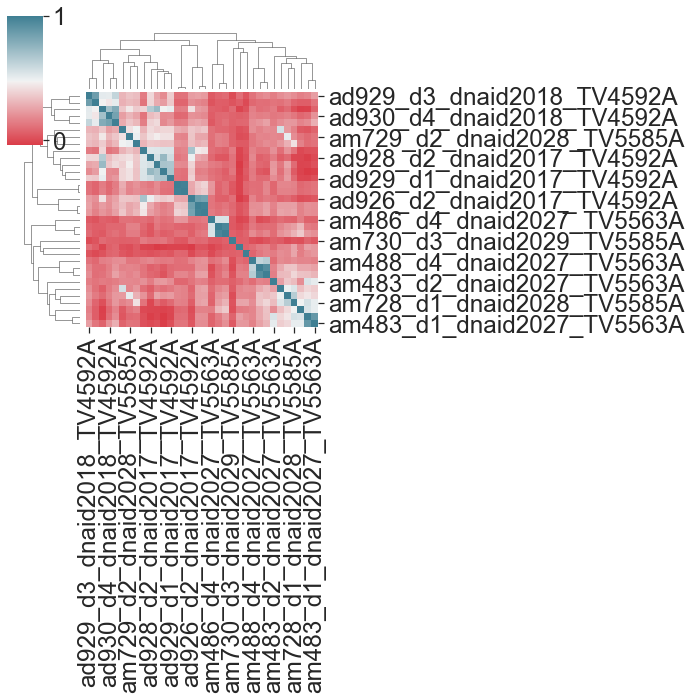

In [371]:
import seaborn as sns
fig = plt.figure(figsize=(20,30))
ax = sns.clustermap(
    library_gene_fitness[[c for c in library_gene_fitness.columns if 'd0' not in c]].corr(), 
    
    cmap=sns.diverging_palette(10, 220, n=256),
    square=True
)

In [28]:
library_gene_fitness.corr()

,ad729_d2_dnaid2015_TV4570,ad726_d2_dnaid2015_TV4570,ad731_d1_dnaid2015_TV4570,ad736_d1_dnaid2015_TV4570,ad730_d2_dnaid2015_TV4570,ad737_d1_dnaid2015_TV4570,ad726_d1_dnaid2015_TV4570,ad728_d1_dnaid2015_TV4570,ad738_d2_dnaid2015_TV4570,ad732_d1_dnaid2015_TV4570,...,ad729_d3_dnaid2016_TV4570,ad728_d3_dnaid2016_TV4570,ad737_d3_dnaid2016_TV4570,ad728_d4_dnaid2016_TV4570,ad726_d4_dnaid2016_TV4570,ad732_d3_dnaid2016_TV4570,ad734_d3_dnaid2016_TV4570,inoculum_d0_dnaid2016_TV4570,ad730_d4_dnaid2016_TV4570,ad729_d4_dnaid2016_TV4570
ad729_d2_dnaid2015_TV4570,1.000000,0.394251,0.698377,0.061500,0.697306,0.723564,0.660841,0.212549,0.723242,0.549963,...,0.374032,0.281003,0.325930,0.039260,0.188773,0.415619,0.405928,0.124933,0.283838,0.255386
ad726_d2_dnaid2015_TV4570,0.394251,1.000000,0.187581,-0.007646,0.192773,0.185485,0.349173,0.070030,0.678576,0.133956,...,0.277520,0.163120,0.575163,0.070158,0.895562,0.696466,0.749218,0.022550,0.521930,0.285000
ad731_d1_dnaid2015_TV4570,0.698377,0.187581,1.000000,0.084685,0.650035,0.731041,0.644117,0.235220,0.511940,0.542217,...,0.068620,0.274891,0.116342,-0.001033,0.025477,0.143796,0.120315,0.140827,0.051392,-0.017881
ad736_d1_dnaid2015_TV4570,0.061500,-0.007646,0.084685,1.000000,0.067889,0.084922,0.054210,0.021710,0.045609,0.053268,...,-0.002126,0.024523,0.000305,-0.006872,-0.024418,-0.005785,0.003849,0.011075,0.028529,-0.012508
ad730_d2_dnaid2015_TV4570,0.697306,0.192773,0.650035,0.067889,1.000000,0.675408,0.626448,0.212796,0.505101,0.506980,...,0.093413,0.267956,0.222937,0.025502,0.036795,0.187789,0.173262,0.100071,0.136306,0.007801
ad737_d1_dnaid2015_TV4570,0.723564,0.185485,0.731041,0.084922,0.675408,1.000000,0.706476,0.243574,0.604577,0.589111,...,0.059742,0.278565,0.154805,0.004386,0.015666,0.141274,0.102261,0.165123,0.025454,-0.021686
ad726_d1_dnaid2015_TV4570,0.660841,0.349173,0.644117,0.054210,0.626448,0.706476,1.000000,0.261377,0.511618,0.544290,...,0.071082,0.290844,0.163869,-0.012010,0.192619,0.171928,0.130230,0.043859,0.045364,0.001811
ad728_d1_dnaid2015_TV4570,0.212549,0.070030,0.235220,0.021710,0.212796,0.243574,0.261377,1.000000,0.171508,0.171591,...,0.011229,0.855346,0.030991,0.097801,0.002703,0.026164,0.014772,0.020247,0.003286,-0.018104
ad738_d2_dnaid2015_TV4570,0.723242,0.678576,0.511940,0.045609,0.505101,0.604577,0.511618,0.171508,1.000000,0.388019,...,0.309957,0.257832,0.661636,0.072080,0.433070,0.747567,0.787625,0.098655,0.541534,0.274292
ad732_d1_dnaid2015_TV4570,0.549963,0.133956,0.542217,0.053268,0.506980,0.589111,0.544290,0.171591,0.388019,1.000000,...,0.074912,0.223896,0.085952,0.049178,-0.002446,0.335354,0.063892,0.080561,-0.000699,-0.002646


In [202]:
good_samples_noskew = [s for s in good_samples if s not in skewed_samples and s not in no_inoc_samples]
fits = []
cis = []
wt_fits = []
ssa_ci = []
resultsFitList = []
resultsCIList=[]
# Fitness Results
for library in libraries:
    print(library)
    library_vst, library_barcode_fitness = get_barcode_fitness_by_library(cnt_df, library, good_samples_noskew, outdir, filter_below=1000)
    library_gene_fitness = get_gene_fitness_by_library(library_barcode_fitness, annotation_df)
    library_wt_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='wt')
    library_ssa_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='ssaV_invG')
    library_gene_ci = library_gene_fitness.set_index('ShortName').apply(lambda x: x / library_wt_fitness.median()[x.name]).reset_index()
    library_ssa_ci = library_ssa_fitness.median()/library_wt_fitness.median()
    meltGeneFit = melt_sampleID(library_gene_fitness, idVar=['ShortName'], value_name='fitness')
    meltWtFit = melt_sampleID(library_wt_fitness, idVar=['barcode', 'phenotype', 'conc'], value_name='fitness')
    meltGeneCI = melt_sampleID(library_gene_ci, idVar=['ShortName'], value_name='ci')
    resultsFit = get_library_results(meltGeneFit, meltWtFit, library)
    resultsCI = get_library_results_ci(meltGeneCI, library_ssa_ci, library)
    
    fits.append(meltGeneFit.assign(library=library))
    cis.append(meltGeneCI.assign(library=library))
    wt_fits.append(meltWtFit.assign(library=library))
    resultsFitList.append(resultsFit)
    resultsCIList.append(resultsCI)
    ssa_ci.append(pd.DataFrame(library_ssa_ci, columns=['ssa_ci']).assign(library=library))
    
m2_fits_no_skew = pd.concat(fits)
m2_ci_no_skew = pd.concat(cis)
m2_wt_fits_no_skew = pd.concat(wt_fits)
m2_results_fit_no_skew = pd.concat(resultsFitList)
m2_results_ci_no_skew = pd.concat(resultsCIList)
m2_ssa_ci_no_skew = pd.concat(ssa_ci)

library_11_1
Number of unique experiments after filtering: 3
Design: experiment+day
d3
d1
d2
d3
d1
d2
library_15_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_13_2
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d2
d1
d3
library_10_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d4
d2
d1
d3
d4
library_9_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_11_2
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_12_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d4
d3
d2
d1
d4
d3
library_12_2
Number of unique experiments after filtering: 2
Design: experiment+day
d2
d3
d4
d1
d2
d3
d4
d1
library_13_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d4
d3
d2
d1
d4
d3
library_14_2
Number of unique experiments after filtering: 3
Design: experiment+day
d1
d2
d4
d3
d1
d2
d4
d3
library_10_2
Number of uniqu

In [203]:

fits = []
cis = []
wt_fits = []
ssa_ci = []
resultsFitList = []
resultsCIList=[]
# Fitness Results
for library in libraries:
    print(library)
    library_vst, library_barcode_fitness = get_barcode_fitness_by_library(cnt_df, library, good_samples, outdir, filter_below=1000)
    library_gene_fitness = get_gene_fitness_by_library(library_barcode_fitness, annotation_df)
    library_wt_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='wt')
    library_ssa_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='ssaV_invG')
    library_gene_ci = library_gene_fitness.set_index('ShortName').apply(lambda x: x / library_wt_fitness.median()[x.name]).reset_index()
    library_ssa_ci = library_ssa_fitness.median()/library_wt_fitness.median()
    meltGeneFit = melt_sampleID(library_gene_fitness, idVar=['ShortName'], value_name='fitness')
    meltWtFit = melt_sampleID(library_wt_fitness, idVar=['barcode', 'phenotype', 'conc'], value_name='fitness')
    meltGeneCI = melt_sampleID(library_gene_ci, idVar=['ShortName'], value_name='ci')
    resultsFit = get_library_results(meltGeneFit, meltWtFit, library)
    resultsCI = get_library_results_ci(meltGeneCI, library_ssa_ci, library)
    
    fits.append(meltGeneFit.assign(library=library))
    cis.append(meltGeneCI.assign(library=library))
    wt_fits.append(meltWtFit.assign(library=library))
    resultsFitList.append(resultsFit)
    resultsCIList.append(resultsCI)
    ssa_ci.append(pd.DataFrame(library_ssa_ci, columns=['ssa_ci']).assign(library=library))
    
m2_fits_skew = pd.concat(fits)
m2_ci_skew = pd.concat(cis)
m2_wt_fits_skew = pd.concat(wt_fits)
m2_results_fit_skew = pd.concat(resultsFitList)
m2_results_ci_skew = pd.concat(resultsCIList)
m2_ssa_ci_skew = pd.concat(ssa_ci)

library_11_1
Number of unique experiments after filtering: 3
Design: experiment+day
d3
d1
d2
d3
d1
d2
library_15_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_13_2
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d2
d1
d3
library_10_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d3
d4
d2
d1
d3
d4
library_9_1
Number of unique experiments after filtering: 1
Design: day
d1
d2
d3
d1
d2
d3
library_11_2
Number of unique experiments after filtering: 2
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



d3
d1
d2
d4
d3
d1
d2
d4
library_12_1
Number of unique experiments after filtering: 1
Design: day
d2
d1
d4
d3
d2
d1
d4
d3
library_12_2
Number of unique experiments after filtering: 3
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



d4
d2
d3
d1
d4
d2
d3
d1
library_13_1
Number of unique experiments after filtering: 2
Design: experiment+day


/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice



d4
d3
d2
d1
d4
d3
d2
d1
library_14_2
Number of unique experiments after filtering: 3
Design: experiment+day
d1
d2
d4
d3
d1
d2
d4
d3
library_10_2
Number of unique experiments after filtering: 3
Design: experiment+day
d1
d2
d4
d3
d1
d2
d4
d3


In [204]:
m2_fits_no_skew.to_csv(Path(outdir)/"21-07-m2_fits_no_skew")
m2_ci_no_skew.to_csv(Path(outdir)/"21-07-m2_ci_no_skew")
m2_wt_fits_no_skew.to_csv(Path(outdir)/"21-07-m2_wt_fits_no_skew")
m2_results_fit_no_skew.to_csv(Path(outdir)/"21-07-m2_results_fit_no_skew")
m2_results_ci_no_skew.to_csv(Path(outdir)/"21-07-m2_results_ci_no_skew")
m2_ssa_ci_no_skew.to_csv(Path(outdir)/"21-07-m2_ssa_ci_no_skew")

In [205]:
m2_fits_skew.to_csv(Path(outdir)/"21-07-m2_fits_skew")
m2_ci_skew.to_csv(Path(outdir)/"21-07-m2_ci_skew")
m2_wt_fits_skew.to_csv(Path(outdir)/"21-07-m2_wt_fits_skew")
m2_results_fit_skew.to_csv(Path(outdir)/"21-07-m2_results_fit_skew")
m2_results_ci_skew.to_csv(Path(outdir)/"21-07-m2_results_ci_skew")
m2_ssa_ci_skew.to_csv(Path(outdir)/"21-07-m2_ssa_ci_skew")

In [33]:
m2_results_fit_no_skew.sample(10)

,ShortName,day,fitness,pval,padj,library
640,GGAAAGACCAGCCCCGA,d2,0.753135,0.083265,0.296472,library_9_1
2523,pgtA,d1,1.073162,0.563703,0.660571,library_12_2
749,SL1344_1068,d3,1.169480,0.121335,0.163930,library_11_2
1645,SL1344_3189,d2,1.244748,0.035692,0.105050,library_14_2
1722,citA2,d1,1.355173,0.200185,0.442767,library_11_1
2246,hisP,d3,0.830726,0.049535,0.203508,library_9_1
3513,rfbC,d2,0.160097,0.001745,0.002464,library_12_1
4336,sipA,d1,1.110428,0.000015,0.000066,library_10_1
1586,SL1344_0704,d3,1.057923,0.092892,0.162316,library_10_1
503,CCGATGCCTAACATGGG,d4,0.879228,0.872780,0.913266,library_10_2


In [68]:
# CI Results: 
library_ssa_fitness = get_wt_fitness_by_library(library_barcode_fitness, annotation_df, phenotype='ssaV_invG')

meltSsaFit = melt_sampleID(library_ssa_fitness, idVar=['barcode', 'phenotype', 'conc'], value_name='fitness')

In [82]:
library_gene_fitness

,ShortName,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,inoculum_d0_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad927_d4_dnaid2018_TV4592A,...,am729_d1_dnaid2028_TV5585A,am727_d1_dnaid2028_TV5585A,am728_d2_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am729_d2_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,inoculum_d0_dnaid2028_TV5585A,am727_d2_dnaid2028_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A
0,AAAAACATGCCACACTG,0.985617,1.155659,0.950663,1.154966,0.774247,0.989935,0.985311,0.936557,0.316228,...,1.061932,1.229496,0.784861,1.896135,0.792150,1.641517,0.990636,1.032761,1.022155,0.156921
1,AAAACTTCATGTACAGA,1.131380,1.073380,1.324666,0.938640,1.330554,0.985547,1.049889,1.824310,0.302450,...,1.107131,1.071218,0.983487,0.602177,1.153758,1.740100,0.963938,1.381632,0.967771,13.994312
2,AAACGGCCGAGTTCGAG,1.129097,1.104905,1.057171,1.200557,0.974491,1.142301,0.908517,0.944754,1.628320,...,1.480389,1.215680,1.533782,0.535945,1.183256,0.951312,1.048617,1.010529,1.034408,0.289434
3,AAACGTCCCCACACGGG,0.914262,0.745342,1.066238,1.080382,1.038991,0.880968,1.036900,0.899503,3.795581,...,0.939222,1.039943,0.734992,1.185250,0.721147,1.358034,1.055841,1.101099,0.998672,2.117587
4,AAAGAAGCTATAAACTA,1.056985,0.497449,0.600516,0.615274,0.657162,0.955564,0.991260,0.728107,0.393152,...,1.032617,2.038784,1.542485,2.927103,1.019399,1.134085,0.985132,0.930290,0.984072,9.768891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,ysaA,1.083773,1.045416,1.032837,1.237190,0.814401,1.011026,1.077172,1.025376,0.798749,...,0.856849,1.435381,1.095987,1.762138,0.590391,1.672280,0.981550,1.052469,0.952687,2.639017
1169,ytfF,0.836409,1.125525,0.904810,0.938944,0.796284,0.836688,1.115906,1.081929,4.083045,...,1.124470,0.911559,0.957682,0.306443,1.797832,1.058680,0.943195,0.877220,0.966512,0.338406
1170,ytfG,0.780452,0.711877,1.347362,0.907275,1.169310,1.291563,1.154237,0.996776,4.251034,...,0.815926,0.891624,0.831352,1.393037,0.680611,0.963812,0.913336,0.843032,0.916037,0.279050
1171,ytfJ,1.101357,0.796243,0.906423,0.874206,0.848025,1.076558,1.132144,0.801071,0.367314,...,0.940369,2.047553,1.337354,0.541298,0.723086,1.245139,0.969877,0.990396,0.915790,1.219283


ad930_d1_dnaid2017_TV4592A       0.115897
ad926_d2_dnaid2017_TV4592A       0.079767
ad928_d2_dnaid2017_TV4592A       0.097087
ad926_d1_dnaid2017_TV4592A       0.131525
ad928_d1_dnaid2017_TV4592A       0.110423
ad930_d2_dnaid2017_TV4592A       0.116667
inoculum_d0_dnaid2017_TV4592A    1.404595
ad929_d1_dnaid2017_TV4592A       0.130403
ad927_d4_dnaid2018_TV4592A       0.150118
ad926_d3_dnaid2018_TV4592A       0.087352
ad927_d3_dnaid2018_TV4592A       0.167404
ad926_d4_dnaid2018_TV4592A       0.073684
ad930_d4_dnaid2018_TV4592A       0.146716
ad930_d3_dnaid2018_TV4592A       0.134040
ad929_d3_dnaid2018_TV4592A       0.167760
ad929_d4_dnaid2018_TV4592A       0.117852
inoculum_d0_dnaid2018_TV4592A    1.379779
am486_d2_dnaid2027_TV5563A       0.124738
am483_d2_dnaid2027_TV5563A       0.199668
am488_d2_dnaid2027_TV5563A       0.194998
inoculum_d0_dnaid2027_TV5563A    0.815780
am486_d3_dnaid2027_TV5563A       0.125105
am486_d4_dnaid2027_TV5563A       0.078461
am488_d4_dnaid2027_TV5563A       0

In [78]:
library_gene_fitness

,ShortName,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,inoculum_d0_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad927_d4_dnaid2018_TV4592A,...,am729_d1_dnaid2028_TV5585A,am727_d1_dnaid2028_TV5585A,am728_d2_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am729_d2_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,inoculum_d0_dnaid2028_TV5585A,am727_d2_dnaid2028_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A
0,AAAAACATGCCACACTG,0.985617,1.155659,0.950663,1.154966,0.774247,0.989935,0.985311,0.936557,0.316228,...,1.061932,1.229496,0.784861,1.896135,0.792150,1.641517,0.990636,1.032761,1.022155,0.156921
1,AAAACTTCATGTACAGA,1.131380,1.073380,1.324666,0.938640,1.330554,0.985547,1.049889,1.824310,0.302450,...,1.107131,1.071218,0.983487,0.602177,1.153758,1.740100,0.963938,1.381632,0.967771,13.994312
2,AAACGGCCGAGTTCGAG,1.129097,1.104905,1.057171,1.200557,0.974491,1.142301,0.908517,0.944754,1.628320,...,1.480389,1.215680,1.533782,0.535945,1.183256,0.951312,1.048617,1.010529,1.034408,0.289434
3,AAACGTCCCCACACGGG,0.914262,0.745342,1.066238,1.080382,1.038991,0.880968,1.036900,0.899503,3.795581,...,0.939222,1.039943,0.734992,1.185250,0.721147,1.358034,1.055841,1.101099,0.998672,2.117587
4,AAAGAAGCTATAAACTA,1.056985,0.497449,0.600516,0.615274,0.657162,0.955564,0.991260,0.728107,0.393152,...,1.032617,2.038784,1.542485,2.927103,1.019399,1.134085,0.985132,0.930290,0.984072,9.768891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,ysaA,1.083773,1.045416,1.032837,1.237190,0.814401,1.011026,1.077172,1.025376,0.798749,...,0.856849,1.435381,1.095987,1.762138,0.590391,1.672280,0.981550,1.052469,0.952687,2.639017
1169,ytfF,0.836409,1.125525,0.904810,0.938944,0.796284,0.836688,1.115906,1.081929,4.083045,...,1.124470,0.911559,0.957682,0.306443,1.797832,1.058680,0.943195,0.877220,0.966512,0.338406
1170,ytfG,0.780452,0.711877,1.347362,0.907275,1.169310,1.291563,1.154237,0.996776,4.251034,...,0.815926,0.891624,0.831352,1.393037,0.680611,0.963812,0.913336,0.843032,0.916037,0.279050
1171,ytfJ,1.101357,0.796243,0.906423,0.874206,0.848025,1.076558,1.132144,0.801071,0.367314,...,0.940369,2.047553,1.337354,0.541298,0.723086,1.245139,0.969877,0.990396,0.915790,1.219283


In [77]:
meltGeneFit

,ShortName,sampleID,fitness,mouse,day,dnaid,experiment
0,AAAAACATGCCACACTG,ad930_d1_dnaid2017_TV4592A,0.985617,ad930,d1,dnaid2017,TV4592A
1,AAAACTTCATGTACAGA,ad930_d1_dnaid2017_TV4592A,1.131380,ad930,d1,dnaid2017,TV4592A
2,AAACGGCCGAGTTCGAG,ad930_d1_dnaid2017_TV4592A,1.129097,ad930,d1,dnaid2017,TV4592A
3,AAACGTCCCCACACGGG,ad930_d1_dnaid2017_TV4592A,0.914262,ad930,d1,dnaid2017,TV4592A
4,AAAGAAGCTATAAACTA,ad930_d1_dnaid2017_TV4592A,1.056985,ad930,d1,dnaid2017,TV4592A
...,...,...,...,...,...,...,...
45742,ysaA,am730_d3_dnaid2029_TV5585A,2.639017,am730,d3,dnaid2029,TV5585A
45743,ytfF,am730_d3_dnaid2029_TV5585A,0.338406,am730,d3,dnaid2029,TV5585A
45744,ytfG,am730_d3_dnaid2029_TV5585A,0.279050,am730,d3,dnaid2029,TV5585A
45745,ytfJ,am730_d3_dnaid2029_TV5585A,1.219283,am730,d3,dnaid2029,TV5585A


In [75]:
meltSsaFit[['sampleID', 'fitness']].set_index('sampleID')/meltWtFit[['sampleID', 'fitness']].set_index('sampleID')

,fitness
sampleID,
ad926_d1_dnaid2017_TV4592A,1.680447
ad926_d1_dnaid2017_TV4592A,1.427444
ad926_d1_dnaid2017_TV4592A,1.602645
ad926_d1_dnaid2017_TV4592A,1.709271
ad926_d1_dnaid2017_TV4592A,1.643606
...,...
inoculum_d0_dnaid2029_TV5585A,0.900185
inoculum_d0_dnaid2029_TV5585A,0.918543
inoculum_d0_dnaid2029_TV5585A,0.996309


In [70]:
meltSsaFit

,barcode,phenotype,conc,sampleID,fitness,mouse,day,dnaid,experiment
0,ACGAGACAGTTTACAAT,ssaV_invG,0.0005,ad930_d1_dnaid2017_TV4592A,1.706932,ad930,d1,dnaid2017,TV4592A
1,ATTTGCACCTGATACCT,ssaV_invG,0.0015,ad930_d1_dnaid2017_TV4592A,1.710705,ad930,d1,dnaid2017,TV4592A
2,ACGAGACAGTTTACAAT,ssaV_invG,0.0005,ad926_d2_dnaid2017_TV4592A,2.590219,ad926,d2,dnaid2017,TV4592A
3,ATTTGCACCTGATACCT,ssaV_invG,0.0015,ad926_d2_dnaid2017_TV4592A,2.243344,ad926,d2,dnaid2017,TV4592A
4,ACGAGACAGTTTACAAT,ssaV_invG,0.0005,ad928_d2_dnaid2017_TV4592A,2.044521,ad928,d2,dnaid2017,TV4592A
...,...,...,...,...,...,...,...,...,...
73,ATTTGCACCTGATACCT,ssaV_invG,0.0015,am727_d2_dnaid2028_TV5585A,2.319077,am727,d2,dnaid2028,TV5585A
74,ACGAGACAGTTTACAAT,ssaV_invG,0.0005,inoculum_d0_dnaid2029_TV5585A,0.935425,inoculum,d0,dnaid2029,TV5585A
75,ATTTGCACCTGATACCT,ssaV_invG,0.0015,inoculum_d0_dnaid2029_TV5585A,0.969596,inoculum,d0,dnaid2029,TV5585A
76,ACGAGACAGTTTACAAT,ssaV_invG,0.0005,am730_d3_dnaid2029_TV5585A,0.395420,am730,d3,dnaid2029,TV5585A


In [67]:
library_ssa_fitness

,barcode,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,inoculum_d0_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad927_d4_dnaid2018_TV4592A,...,am728_d2_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am729_d2_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,inoculum_d0_dnaid2028_TV5585A,am727_d2_dnaid2028_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A,phenotype,conc
2,ACGAGACAGTTTACAAT,1.706932,2.590219,2.044521,1.533299,1.766350,1.577067,1.076987,1.502465,0.770828,...,2.304343,0.804085,1.774821,1.054665,0.962158,1.979901,0.935425,0.39542,ssaV_invG,0.0005
6,ATTTGCACCTGATACCT,1.710705,2.243344,1.926987,1.428646,1.748098,1.727801,1.058093,1.490068,1.797542,...,3.496821,0.918104,2.291487,1.178258,0.971776,2.319077,0.969596,1.69383,ssaV_invG,0.0015


In [61]:
y = meltGeneFit[['ShortName', 'day']].drop_duplicates()
y[y.day !='d0'].shape

(4692, 2)

In [55]:
x = results.merge(meltGeneFit[['ShortName', 'day']].drop_duplicates(), on=['ShortName', 'day'])

In [62]:
results.shape

(4692, 4)

In [14]:
fit_dfs = []
gene_fit_dfs = []
ci_dfs = []
res_dfs = []
wt_fit_dfs = []
ssa_ci_dfs = []

for library in ['library_10_2']:
    print(library)
    lib_df = cnt_df[cnt_df.library == library].copy()
    #Removing some noise
    lib_df = lib_df[~((lib_df.libcnt.isna()) & (lib_df.phenotype.isna()))]
    library_samples = [s for s in good_samples if s in lib_df.sampleID.unique() and s not in skewed_samples]
    sdf, edf, design = generate_DE_dataset(lib_df, library_samples, sample_id='sampleID', filter_below=1000)
    _, vst_df = get_fitness_results(outdir, library.replace("_", "-"), '', sdf, edf, design)
    method2_results = method2_analysis2(vst_df, annotation_df, library_samples, sample_id='sampleID', hits=0.05)
    
    for df in method2_results:
        if not df.empty:
            df['library'] = library
    all_fitness_df, gene_fitness_df, ci_df, results_df, wt_fitness_df, ssa_ci_df = method2_results    
    fit_dfs.append(all_fitness_df)
    gene_fit_dfs.append(gene_fitness_df)
    ci_dfs.append(ci_df)
    res_dfs.append(results_df)
    wt_fit_dfs.append(wt_fitness_df)
    ssa_ci_dfs.append(ssa_ci_df)
    
fit2 = pd.concat(fit_dfs)
fit2_gene = pd.concat(gene_fit_dfs)
wt_fit2 = pd.concat(wt_fit_dfs)
ssa_ci2 = pd.concat(ssa_ci_dfs)

library_10_2
Number of unique experiments after filtering: 3
Design: experiment+day


TypeError: get_barcode_fitness() takes 1 positional argument but 3 were given

In [7]:
res2 = pd.concat(res_dfs)

In [10]:
res2.sample(5, random_state=100)

,pval,padj,ci_pval,ci_padj,median_fitness,mean_fitness,median_CI,mean_CI,hits,ci_hits,day,library
ShortName,,,,,,,,,,,,
GCATAGAACAGAACTGG,0.462240,0.726653,0.645892,0.990097,0.899415,0.986186,1.088555,1.229796,False,False,d2,library_10_2
IsrB-1,0.015169,0.038340,0.691102,0.767530,1.067449,1.555315,1.597799,2.296619,True,False,d4,library_10_2
hybC,0.053631,0.248786,0.581379,0.990097,1.000000,1.000000,1.102998,1.265442,False,False,d2,library_10_2
dbh,0.145120,0.213386,0.145120,0.353532,0.873830,0.921531,1.335924,1.452658,False,False,d4,library_10_2
slrP,0.854178,0.930576,0.270138,0.763504,0.967535,0.952813,0.986406,1.113290,False,False,d2,library_10_2


In [14]:
results_df.groupby('day').padj.count()
#print('Tested 1888 genes/barcodes')
for day in ['d1', 'd2', 'd3', 'd4']:
    print(f'Number of significant hits on {day}: {res2[(res2.day == day)&(res2.ci_padj < 0.05)].shape[0]}')
    
    

Number of significant hits on d1: 115
Number of significant hits on d2: 96
Number of significant hits on d3: 271
Number of significant hits on d4: 94


In [23]:
def get_control_df(fitness, phenotype='wt'):
    fitness.columns = [c.replace("unenriched_", "unenriched-") for c in fitness.columns]
    fitness = fitness.drop(['day'], axis=1)

    wt = fitness[fitness.phenotype == phenotype].dropna(axis=1).drop(['inoculum'], axis=1)
    wt = wt.melt(id_vars=['barcode', 'phenotype', 'conc', 'library'], var_name='sampleID', value_name='fitness')
    new = wt.sampleID.str.split("_", expand=True)
    new.columns = ['mouse', 'day', 'dnaid', 'experiment']
    wt = wt.merge(new, left_index=True, right_index=True)
    return wt

wt = get_control_df(all_fitness_df)

In [24]:
wt

,barcode,phenotype,conc,library,sampleID,fitness,mouse,day,dnaid,experiment
0,AACAACACGGTAAGCAA,wt,0.000019,library_10_2,ad927_d1_dnaid2017_TV4592A,0.276852,ad927,d1,dnaid2017,TV4592A
1,ACAGAGCTCGGGAGTCT,wt,0.000167,library_10_2,ad927_d1_dnaid2017_TV4592A,1.439026,ad927,d1,dnaid2017,TV4592A
2,ACTACAAGACTGGTTAA,wt,0.000056,library_10_2,ad927_d1_dnaid2017_TV4592A,0.153214,ad927,d1,dnaid2017,TV4592A
3,AGAATGACCCGGAGGCT,wt,0.001500,library_10_2,ad927_d1_dnaid2017_TV4592A,1.252950,ad927,d1,dnaid2017,TV4592A
4,AGATGCATGACTAGCTA,wt,0.000019,library_10_2,ad927_d1_dnaid2017_TV4592A,0.237015,ad927,d1,dnaid2017,TV4592A
...,...,...,...,...,...,...,...,...,...,...
4375,GTGTATAGCAGGAACCC,wt,0.000167,library_10_2,am727_d4_dnaid2029_TV5585A,0.622485,am727,d4,dnaid2029,TV5585A
4376,TAAGTCCGGGCTAAGTC,wt,0.000056,library_10_2,am727_d4_dnaid2029_TV5585A,1.809642,am727,d4,dnaid2029,TV5585A
4377,TACCCAGAGCACACTCA,wt,0.001500,library_10_2,am727_d4_dnaid2029_TV5585A,4.420666,am727,d4,dnaid2029,TV5585A
4378,TATAACACCCCCGATTC,wt,0.001500,library_10_2,am727_d4_dnaid2029_TV5585A,1.274228,am727,d4,dnaid2029,TV5585A


In [71]:
day = 'd3'
wt_d1 = wt[wt.day == day]
fig = px.box(wt_d1, x='mouse', y=np.log2(wt_d1['fitness']), color='mouse',  hover_data=['conc', 'fitness'],
        template='simple_white', title = f'WT-{day}',
              labels={"y": "log2(Fitness)",
                     "conc": "Dilution", "fitness": "Fitness"})
fig.add_hline(y=0, line_width=3, line_dash="dash")

In [73]:
wt_fit2

,wt,ssaV_invG,day,library
ad926_d1_dnaid2017_TV4592A,0.936862,1.369418,d1,library_10_2
ad927_d1_dnaid2017_TV4592A,0.624402,0.912895,d1,library_10_2
ad928_d1_dnaid2017_TV4592A,1.139436,1.605650,d1,library_10_2
ad929_d1_dnaid2017_TV4592A,1.050117,1.389896,d1,library_10_2
ad930_d1_dnaid2017_TV4592A,0.969890,1.561267,d1,library_10_2
am483_d1_dnaid2027_TV5563A,0.889479,1.063385,d1,library_10_2
am484_d1_dnaid2027_TV5563A,0.993042,1.188904,d1,library_10_2
am485_d1_dnaid2027_TV5563A,0.812440,1.381029,d1,library_10_2
am486_d1_dnaid2027_TV5563A,0.880989,1.264310,d1,library_10_2
am488_d1_dnaid2027_TV5563A,0.859587,0.923356,d1,library_10_2


In [76]:
filter_skewed = wt.groupby('sampleID').agg({'fitness': [lambda x: x.quantile(0.25),  lambda x: x.quantile(0.75)]}).reset_index()
filter_skewed.columns = ['sampleID', 'lowQ', 'highQ']
filter_skewed = filter_skewed[~(filter_skewed.lowQ<1.1)&(filter_skewed.highQ>0.9)]
to_drop = filter_skewed.sampleID.values

In [77]:
to_drop

array(['am487_d1_dnaid2027_TV5563A', 'am732_d1_dnaid2028_TV5585A'],
      dtype=object)

In [40]:
res2.loc['rfaI']

,pval,padj,ci_pval,ci_padj,median_fitness,mean_fitness,median_CI,mean_CI,hits,ci_hits,day,library
ShortName,,,,,,,,,,,,
rfaI,0.000032,0.001523,0.000032,0.002639,0.048985,0.049393,0.057993,0.053767,True,True,d1,library_10_2
rfaI,0.000349,0.007835,0.000349,0.008775,0.018602,0.019584,0.016319,0.018709,True,True,d2,library_10_2
rfaI,0.009023,0.042379,0.009023,0.230220,0.015343,0.016550,0.023224,0.022739,True,False,d3,library_10_2
rfaI,0.020921,0.249997,0.020921,0.598088,0.015343,0.016565,0.019852,0.020175,False,False,d4,library_10_2


In [42]:
wt_fit2.groupby('day').wt.mean()

day
d1    0.921053
d2    1.090822
d3    0.741460
d4    0.831411
Name: wt, dtype: float64

In [46]:
def gene_ranksums(gene_values, wt_values):
    return ranksums(gene_values, wt_values)[1]

In [57]:
gv = ci2[(ci2.ShortName == 'rfaI') & (ci2.day == 'd4')].CI.values
wv = ssa_ci2.loc[ssa_ci2.day == 'd4'].CI.values
gene_ranksums(gv, wv)

0.020921335337794014

In [60]:
res2.loc['rfaI']

,pval,padj,ci_pval,ci_padj,median_fitness,mean_fitness,median_CI,mean_CI,hits,ci_hits,day,library
ShortName,,,,,,,,,,,,
rfaI,0.000032,0.001523,0.000032,0.002639,0.048985,0.049393,0.057993,0.053767,True,True,d1,library_10_2
rfaI,0.000349,0.007835,0.000349,0.008775,0.018602,0.019584,0.016319,0.018709,True,True,d2,library_10_2
rfaI,0.009023,0.042379,0.009023,0.230220,0.015343,0.016550,0.023224,0.022739,True,False,d3,library_10_2
rfaI,0.020921,0.249997,0.020921,0.598088,0.015343,0.016565,0.019852,0.020175,False,False,d4,library_10_2


In [23]:
# Day 1

In [25]:
res1.columns

Index(['locus', 'num_barcodes', 'library', 'barcode', 'sstart', 'sseqid',
       'd1_num_samples', 'd1_fitness_mean', 'd1_fitness_std', 'd1_ci',
       'd1_zscore', 'd1_pval', 'd1_padj', 'd2_num_samples', 'd2_fitness_mean',
       'd2_fitness_std', 'd2_ci', 'd2_zscore', 'd2_pval', 'd2_padj',
       'd3_num_samples', 'd3_fitness_mean', 'd3_fitness_std', 'd3_ci',
       'd3_zscore', 'd3_pval', 'd3_padj', 'd4_num_samples', 'd4_fitness_mean',
       'd4_fitness_std', 'd4_ci', 'd4_zscore', 'd4_pval', 'd4_padj'],
      dtype='object')

In [32]:
t.day.str.split("_")

0        [d1, fitness, mean]
1        [d1, fitness, mean]
2        [d1, fitness, mean]
3        [d1, fitness, mean]
4        [d1, fitness, mean]
                ...         
49243    [d4, fitness, mean]
49244    [d4, fitness, mean]
49245    [d4, fitness, mean]
49246    [d4, fitness, mean]
49247    [d4, fitness, mean]
Name: day, Length: 49248, dtype: object

In [5]:
ivars = ['gene', 'locus', 'num_barcodes', 'library', 'barcode', 'sstart', 'sseqid']
vvars = ['num_samples', 'fitness_mean', 'fitness_std', 'ci', 'zscore', 'pval', 'padj']
df_list = []
for v in vvars:
    t = res1.reset_index().melt(id_vars = ivars, value_vars=[c for c in res1.columns if v in c], value_name=v, var_name='day')
    t['day'] = t.day.str.split("_", expand=True)[0]
    df_list.append(t)
res1m = pd.concat(df_list, axis=1)
res1m = res1m.loc[:, ~res1m.columns.duplicated()]

In [7]:
def significant()

In [8]:
res1m.groupby(['library', 'day']).agg({'padj': [significant]})

padj
                 significant
library      day            
library_10_1 d1         95.0
             d2        106.0
             d3        164.0
             d4        239.0
library_10_2 d1         43.0
             d2         45.0
             d3        351.0
             d4         94.0
library_11_1 d1         17.0
             d2         44.0
             d3         56.0
             d4        267.0
library_11_2 d1         11.0
             d2         27.0
             d3         37.0
             d4        127.0
library_12_1 d1         26.0
             d2        100.0
             d3        137.0
             d4        419.0
library_12_2 d1        420.0
             d2         51.0
             d3         43.0
             d4        445.0
library_13_1 d1         28.0
             d2         44.0
             d3         61.0
             d4        206.0
library_13_2 d1          1.0
             d2          9.0
             d3         16.0
             d4         72.0
library_14_2 d1         61.0
             d2         89.0
             d3        141.0
             d4        309.0
library_15_1 d1          2.0
             d2         27.0
             d3         45.0
             d4        148.0
library_9_1  d1         23.0
             d2         41.0
             d3         58.0
             d4        125.0

In [11]:
res2.groupby(['library', 'day']).agg({'ci_padj': [significant]})

ci_padj
                 significant
library      day            
library_10_1 d1        632.0
             d2        592.0
             d3        764.0
             d4       1084.0
library_10_2 d1        196.0
             d2         96.0
             d3        139.0
             d4         94.0
library_11_1 d1          0.0
             d2          0.0
             d3          0.0
             d4          0.0
library_11_2 d1          0.0
             d2        400.0
             d3        874.0
             d4       1147.0
library_12_1 d1        285.0
             d2       1132.0
             d3       1086.0
             d4       1095.0
library_12_2 d1        299.0
             d2         68.0
             d3        202.0
             d4        140.0
library_13_1 d1         48.0
             d2          0.0
             d3          0.0
             d4          0.0
library_13_2 d1          0.0
             d2          0.0
             d3        605.0
             d4        456.0
library_14_2 d1        248.0
             d2        763.0
             d3         61.0
             d4        848.0
library_15_1 d1          0.0
             d2          0.0
             d3          0.0
             d4          0.0
library_9_1  d1          0.0
             d2         24.0
             d3          0.0
             d4          0.0

In [76]:
res1m[(res1m.library == 'library_10_2') & (res1m.day=='d1')].sort_values('padj').head(25)

,gene,locus,num_barcodes,library,barcode,sstart,sseqid,day,num_samples,fitness_mean,fitness_std,ci,zscore,pval,padj
12018,rfaI,SL1344_3684,6.0,library_10_2,"ACCAAAGCCCTCTGACA, AGCCGGGGTGCAACTAC, AGTAAGCA...",NaN,NaN,d1,14.0,-4.824575,2.036850,0.022029,-10.342237,4.538160e-25,5.359567e-22
11789,aph(3'')-Ib,SL1344_RS24735;old_SL1344_P3_0014,1.0,library_10_2,ATCTATCCAAACTCGAA,8430.0,NC_017719.1,d1,14.0,-2.881884,NaN,0.084686,-6.531529,6.510154e-11,3.844246e-08
11949,manA,SL1344_1397,1.0,library_10_2,TAATCGACCTACGTTCC,1497693.0,FQ312003.1,d1,14.0,-1.465193,NaN,0.226088,-6.061719,1.346747e-09,3.976272e-07
12013,purD,SL1344_4114,1.0,library_10_2,TAATCCGACTTTGAAGC,4412731.0,FQ312003.1,d1,14.0,-7.713984,NaN,0.002973,-6.074433,1.244268e-09,3.976272e-07
12025,rfbG,SL1344_2068,2.0,library_10_2,"AAGTAGGGACTAGGACA, TACACCTGAAAGCCCGC",NaN,NaN,d1,14.0,-3.344582,0.002428,0.061450,-5.944682,2.769942e-09,6.542604e-07
11680,SL1344_RS24250,SL1344_RS24250;old_SL1344_P2_0012,7.0,library_10_2,"ACGTGCACCTGTAATGC, ATTCGACGTGTGGGACA, CCCAGGTA...",NaN,NaN,d1,14.0,-0.609447,0.322960,0.409150,-5.638054,1.719831e-08,3.385200e-06
12020,rfaL,SL1344_3679,2.0,library_10_2,"ACAGGAAAACACGCGCC, GTGGACACACCAAGGGC",NaN,NaN,d1,14.0,-1.965638,0.256562,0.159819,-5.576070,2.460134e-08,4.150597e-06
11866,frdA,SL1344_4280,2.0,library_10_2,"CACACCCAAAGTGGGAG, TCGGTCTTACAACCTTA",NaN,NaN,d1,14.0,-2.546077,0.911076,0.106880,-5.436892,5.421799e-08,7.570612e-06
11751,TCTATAACCGCAGCGCC,NaN,1.0,library_10_2,TCTATAACCGCAGCGCC,3934962.0,FQ312003.1,d1,14.0,-5.374529,NaN,0.015047,-5.425808,5.769307e-08,7.570612e-06
11752,TCTATAACCGCAGCGCC,NaN,1.0,library_10_2,TCTATAACCGCAGCGCC,NaN,NaN,d1,14.0,-5.374529,NaN,0.015047,-5.425808,5.769307e-08,7.570612e-06


In [84]:
wt_fit2[wt_fit2.library == 'library_11_1']

,wt,ssaV_invG,day,library
u402_d1_dnaid1315_TV3371A,0.008292,0.017671,d1,library_11_1
u405_d1_dnaid1315_TV3371B,0.678438,2.394979,d1,library_11_1
u406_d1_dnaid1315_TV3371B,0.532848,2.946363,d1,library_11_1
u441_d1_dnaid1315_TV3379,1.051072,2.358702,d1,library_11_1
u442_d1_dnaid1315_TV3379,1.070952,1.269335,d1,library_11_1
u443_d1_dnaid1315_TV3379,0.934999,1.146366,d1,library_11_1
u402_d2_dnaid1315_TV3371A,0.002653,0.020462,d2,library_11_1
u405_d2_dnaid1315_TV3371B,0.319057,1.850958,d2,library_11_1
u406_d2_dnaid1315_TV3371B,0.316180,2.191668,d2,library_11_1
u441_d2_dnaid1315_TV3379,0.756542,1.280023,d2,library_11_1


In [85]:
for library in ['library_10_2']:
    print(library)
    lib_df = cnt_df[cnt_df.library == library].copy()
    library_samples = [s for s in good_samples if s in lib_df.sampleID.unique()]
    vst_df = run_VST_transformation(lib_df, library.replace("_", '-'), good_samples, 
                                    outdir, sample_id='sampleID').set_index('barcode')
    method2_results = method2_analysis(vst_df, annotation_df, library_samples, sample_id='sampleID', hits=0.05)

library_10_2
Generating datasets for DESeq2
Running DESeq2 VST Transformation
Done
_d1
_d2
_d3
_d4


In [87]:
vst_df.sample(5, random_state=5)

,ad927_d1_dnaid2017_TV4592A,ad927_d2_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,ad926_d2_dnaid2017_TV4592A,unenriched_inoculum_d0_dnaid2017_TV4592A,ad928_d2_dnaid2017_TV4592A,ad926_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad930_d2_dnaid2017_TV4592A,inoculum_d0_dnaid2017_TV4592A,...,am727_d3_dnaid2029_TV5585A,inoculum_d0_dnaid2029_TV5585A,am730_d3_dnaid2029_TV5585A,am731_d3_dnaid2029_TV5585A,am732_d3_dnaid2029_TV5585A,am730_d4_dnaid2029_TV5585A,am728_d4_dnaid2029_TV5585A,am732_d4_dnaid2029_TV5585A,am727_d4_dnaid2029_TV5585A,inoculum
barcode,,,,,,,,,,,,,,,,,,,,,
ACGATAACTGGACGCTT,11.066201,11.064530,10.634415,11.660064,10.797948,10.936086,10.764952,10.648320,10.968177,11.128134,...,11.287623,10.828431,10.802672,5.175039,5.175039,9.623614,10.624711,6.137831,11.902319,10.963606
ATGGACGGCACACTCCC,11.706479,11.706686,12.059522,11.797441,11.615572,11.273328,11.733275,11.259607,11.906936,11.651540,...,12.865691,11.725871,11.097955,11.772119,14.055350,10.982670,13.165730,13.094369,14.500963,11.675215
TACCGCGTGCTAGTCCG,5.512735,5.562311,5.567275,5.869913,6.465391,5.770070,5.678367,5.811396,5.965867,5.511437,...,5.175039,5.175039,5.175039,5.175039,5.175039,5.175039,5.175039,5.175039,5.175039,5.341112
TTCTTCATAAGGTCCGG,12.072957,12.024420,11.472487,11.614482,11.488527,11.655261,11.354684,11.712095,11.345765,11.362098,...,11.447505,11.608444,13.346289,11.950405,5.175039,12.168333,9.800672,5.175039,11.032783,11.521859
GCAGTGACACTTGAAAG,12.305110,12.813021,12.525742,12.643789,12.101349,13.031319,12.666074,12.884261,12.861985,12.862726,...,12.239184,12.815019,15.800145,12.320189,11.885109,15.799058,9.690098,10.846541,11.899486,12.813601


In [88]:
all_fitness_df, gene_fitness_df, ci_df, results_df, wt_fitness_df, ssa_ci_df = method2_results

In [89]:
results_df.sample(5, random_state=42)

,pval,padj,ci_pval,ci_padj,median_fitness,mean_fitness,median_CI,mean_CI,hits,ci_hits,day
ShortName,,,,,,,,,,,
ccmF2,0.001781,0.031730,0.008818,0.050452,1.837244,15.577699,1.850051,5.847329,True,False,d1
GATTAACGCACACGCGA,1.000000,1.000000,0.214758,0.371304,0.931440,1.067029,1.101870,1.045520,False,False,d1
SL1344_2671,0.645892,0.874780,0.010080,0.055323,0.911936,3.826027,0.954138,1.681224,False,False,d1
TAACGGTAAGGGGGCGT,0.233230,0.611581,0.037977,0.087334,0.844177,0.985796,0.897858,0.926275,False,False,d2
AACACCTGTTGGAAAAT,0.550294,0.814228,0.141474,0.286283,0.879331,1.034453,1.080840,1.016296,False,False,d1


In [90]:
results_df.ci_hits.sum()

799

In [478]:
cnt_df.head()

,barcode,cnt,libcnt,sstart,sseqid,sstrand,multimap,ShortName,locus_tag,sampleName,...,experiment,mouse,day,tissue,dnaid,sampleID,send,DN,phenotype,conc
0,AAAAAACAATAAAAAGA,5691.0,1174.0,3738295.0,FQ312003.1,minus,False,SL1344_3513,SL1344_3513,dnaid1315_17,...,TV3379,u441,d1,feces,dnaid1315,u441_d1_dnaid1315_TV3379,NaN,NaN,NaN,NaN
1,AAAAACTTTCCTGTGTT,2846.0,1228.0,1664201.0,FQ312003.1,minus,False,SL1344_1548,SL1344_1548,dnaid1315_17,...,TV3379,u441,d1,feces,dnaid1315,u441_d1_dnaid1315_TV3379,NaN,NaN,NaN,NaN
2,AAAAAGGACAATATGCG,3855.0,2528.0,2042376.0,FQ312003.1,plus,False,SL1344_1929,SL1344_1929,dnaid1315_17,...,TV3379,u441,d1,feces,dnaid1315,u441_d1_dnaid1315_TV3379,NaN,NaN,NaN,NaN
3,AAAAAGGACAATATGCG,3855.0,2528.0,2042376.0,FQ312003.1,plus,False,SL1344_1930,SL1344_1930,dnaid1315_17,...,TV3379,u441,d1,feces,dnaid1315,u441_d1_dnaid1315_TV3379,NaN,NaN,NaN,NaN
4,AAAACAATCTATCGACC,6515.0,3587.0,44168.0,NC_017718.1,plus,False,excA,SL1344_RS24480;old_SL1344_P2_0055,dnaid1315_17,...,TV3379,u441,d1,feces,dnaid1315,u441_d1_dnaid1315_TV3379,NaN,NaN,NaN,NaN


In [511]:
vst_test = cnt_df[(cnt_df.library=='library_10_2') & (cnt_df.day == 'd1')][['barcode', 'cnt', 'sampleID']].drop_duplicates()

vst_test = vst_test.set_index('barcode').pivot(columns='sampleID').fillna(0)
vst_test.columns = [c[1] for c in vst_test.columns]

In [512]:
vst_test

,ad926_d1_dnaid2017_TV4592A,ad927_d1_dnaid2017_TV4592A,ad928_d1_dnaid2017_TV4592A,ad929_d1_dnaid2017_TV4592A,ad930_d1_dnaid2017_TV4592A,am483_d1_dnaid2027_TV5563A,am484_d1_dnaid2027_TV5563A,am485_d1_dnaid2027_TV5563A,am486_d1_dnaid2027_TV5563A,am487_d1_dnaid2027_TV5563A,am488_d1_dnaid2027_TV5563A,am727_d1_dnaid2028_TV5585A,am728_d1_dnaid2028_TV5585A,am729_d1_dnaid2028_TV5585A,am730_d1_dnaid2028_TV5585A,am731_d1_dnaid2028_TV5585A,am732_d1_dnaid2028_TV5585A
barcode,,,,,,,,,,,,,,,,,
AAAAAAACTGTAGTGCA,4711.0,5233.0,4591.0,3910.0,5208.0,2740.0,2478.0,1934.0,905.0,73.0,1524.0,5488.0,2500.0,4933.0,10401.0,1654.0,4655.0
AAAAAACGTCCGCGATG,4455.0,2828.0,4241.0,3377.0,5154.0,5079.0,4809.0,6380.0,2770.0,29.0,4760.0,10980.0,6524.0,5466.0,8.0,17504.0,12.0
AAAAACATGCCACACTG,6688.0,1684.0,4427.0,4751.0,7201.0,7196.0,7581.0,1572.0,1585.0,21.0,5290.0,8530.0,9258.0,8009.0,376.0,8330.0,6654.0
AAAAACGCCGTTAAACT,1994.0,2004.0,1343.0,852.0,1931.0,1039.0,830.0,596.0,350.0,8.0,1351.0,2060.0,1108.0,1815.0,586.0,0.0,9.0
AAAAACTTTATACTTGA,4451.0,2451.0,2872.0,2706.0,4851.0,4345.0,3195.0,3969.0,2049.0,31.0,2977.0,6547.0,5407.0,6360.0,3.0,10321.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTCTTTTACGCACCA,5380.0,3632.0,3766.0,4764.0,8291.0,7260.0,9937.0,4137.0,3848.0,45.0,5716.0,13351.0,10460.0,10797.0,8423.0,3546.0,24.0
TTTTGCAACAGAATGAG,506.0,2553.0,545.0,428.0,216.0,399.0,600.0,0.0,0.0,13.0,637.0,3125.0,828.0,648.0,0.0,0.0,0.0
TTTTTAATCCAAAGCCT,168.0,0.0,140.0,81.0,111.0,0.0,39.0,0.0,0.0,0.0,400.0,514.0,118.0,119.0,0.0,0.0,0.0


In [526]:
px.scatter(x=vst_test.mean(axis=1), y=vst_test.var(axis=1)/vst_test.mean(axis=1), log_x=True, log_y=True)

In [565]:
step1 = np.log(vst_test)
step2 = step1.mean(axis=1)
step3 = step2.replace([np.inf, -np.inf], np.nan).dropna()

step4 = step1.T.apply(lambda x: x - x.mean()).T.replace([np.inf, -np.inf], np.nan).dropna()
step5 = step4.median()

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



In [571]:
scaling_factors = step5.apply(math.exp)

In [572]:
scaling_factors

ad926_d1_dnaid2017_TV4592A    2.145483
ad927_d1_dnaid2017_TV4592A    2.264335
ad928_d1_dnaid2017_TV4592A    1.977308
ad929_d1_dnaid2017_TV4592A    1.801809
ad930_d1_dnaid2017_TV4592A    2.649205
am483_d1_dnaid2027_TV5563A    1.639789
am484_d1_dnaid2027_TV5563A    1.674213
am485_d1_dnaid2027_TV5563A    0.750731
am486_d1_dnaid2027_TV5563A    0.453821
am487_d1_dnaid2027_TV5563A    0.027705
am488_d1_dnaid2027_TV5563A    1.260333
am727_d1_dnaid2028_TV5585A    2.581366
am728_d1_dnaid2028_TV5585A    2.207681
am729_d1_dnaid2028_TV5585A    2.738560
am730_d1_dnaid2028_TV5585A    0.840149
am731_d1_dnaid2028_TV5585A    1.665195
am732_d1_dnaid2028_TV5585A    0.038221
dtype: float64

In [574]:
scaling_factors['ad926_d1_dnaid2017_TV4592A']

2.14548303426351

In [576]:
norm_vst = vst_test.apply(lambda x: x/scaling_factors[x.name])

In [533]:
import math
math.exp(7.69)

2186.374562228241

In [578]:
px.scatter(x=norm_vst.mean(axis=1), y=norm_vst.var(axis=1)/vst_test.mean(axis=1), log_x=True, log_y=True)